# HMM exact inference

This demo shows exact inference on a HMM with known, discrete transition and emission distributions that are fixed over time. It does alpha recursion, which is a sum-product algorithm on HMMs.

The problem is taken from Example 23.3 from ["Bayesian Reasoning and Machine Learning"](http://www.cs.ucl.ac.uk/staff/d.barber/brml/), and this is more or less a port of the provided Matlab implementation with my commentary.

I'm trying to understand how my probabilistic graphical modelling class can be represented in code, so I try to go through this painfully slow and show how the `numpy` arrays map to the discrete probability distributions.

## Problem

The idea is that there's someone moving around a room. You can't see them, but you can hear bumps and creaks from them moving around. You know the probability of someone bumping or creaking at each location in the room. You also know how one moves around the room.
Using the sequence of bumps and/or creaks, the goal is to figure out the locations in the room.

### HMMs

![HMM diagram](2018-05-02-hmm.png)

This problem can be modeled using a Hidden Markov Model. At each timestep $t$ in the sequence, there's the visible state $v_t$ (the bump/creak combination) and the hidden state $h_t$ (the location in the room.)

The goal of *filtering* is to show the probability distribution over the locations in the room at a given timestep $t$ given the bumps/creaks from the current and previous timesteps, $p(h_t\mid v_{1:t})$. Plotting this distribution at each timestep gives a heatmap of where in the room we think the person is. 

In this model, there is a transition distribution $p(h_t \mid h_{t - 1})$ to show that each hidden state depends on the previous timestep's hidden state. There also is the emission distribution $p(v_t \mid h_t)$ to show each visible state depends on the corresponding hidden state. There's also the probability of where in the room the person starts, $p(h_1)$.

The rest of the notebook shows:
 - Setting up the known distributions $p(h_1)$, $p(h_t \mid h_{t - 1})$, and $p(v_t \mid h_t)$. This is a lot of the notebook!
 - Generating some data for the locations ($h_{1:t}$) and sounds ($v_{1:t}$) from that distribution.
 - Finally I get to alpha recursion. I try to predict $h_{1:t}$ based on $v_{1:t}$, $p(h_1)$, $p(h_t \mid h_{t - 1})$, and $p(v_t \mid h_t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper functions you can skip over :D

def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

## Distributions

Before anything, I'll set up the room. I want a $6 \times 5$* room with a total of 30 possible locations. 

In HMM, this means there are 30 hidden states, and at each timestep $t$, $h_t \in \{0,...,29 \}$. Heads up, I'm using index-at-1 notation for the variables to match the book's notation and index-at-0 for states and code.

In `numpy`, I'll set a `width` and `height` for the room and `num_hidden_states` as the total possible locations in the room. While I'm here, I'll set up `map_x_y_to_hidden_state_id` as a convenient way to map from an `x` and `y` coordinate to the index of the state. 

*The original example used a $5\times5$ room, but I didn't want to accidentally transpose my math, so I made it a rectangular room instead.

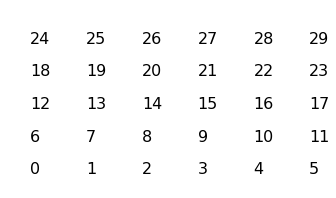

In [3]:
width = 6
height = 5
num_hidden_states = width * height

map_x_y_to_hidden_state_id = np.arange(num_hidden_states).reshape(height, width).T

fig, ax = plt.subplots(figsize=(3, 3))
ax.axis('off')
for x in range(width):
    for y in range(height):
        ax.text(x / 3, y / 5, str(map_x_y_to_hidden_state_id[x][y]), fontsize='16')
plt.show()

### Initial distribution (starting location) $p(h_1)$

The initial distribution $p(h_1)$ gives the probability over the hidden states at the first timestep.

In this case, it's the probability over locations in the room where the person is at the first timestep. The Barber book uses a uniform distribution for this problem. This means at the first timestep, they could be anywhere in the room.

To represent $p(h_1)$ as a `numpy` array `p_hidden_start`:
 - The distribution is uniform, so all values in the array should be the same.
 - The distribution's domain is the possible hidden states, so the array should have the same size `(30,)`.*
 - The array represents a probability distribution so it should sum to 1 and each value should be greater than or equal to 0.
 
*Technically this distribution can be specified with only 29 values because it has to sum to 1. But I'm not going to worry about that here.

In [4]:
# prob of starting starting locations
p_hidden_start = np.ones(num_hidden_states) / num_hidden_states

# verify it's a valid probability distribution
assert np.all(np.isclose(np.sum(p_hidden_start), 1))
assert np.all(p_hidden_start >= 0)

### Transition (moving around the room) $p(h_t \mid h_{t-1})$

Given the previous location, the transition distribution $p(h_t \mid h_{t-1})$ gives the probability of moving to a new location. 

For this problem, the person can only move up, down, left, or right and they can't stand still. This can be encoded in a probability distribution, which is cool! I'll set the value to 0 when it's an illegal move and otherwise evenly distribute it among the legal moves.

Using this I can define $p(h_t, h_{t - 1})$, which I can use to find $p(h_t \mid h_{t-1})$. Translating to `numpy`:
 - This distribution defines probabilities for every combination of two hidden states, so it will have $30 \times 30$ values*. To make things easier when I compute $p(h_t \mid h_{t - 1})$, I'll use a `(30, 30)` array. I'll have `p_transition_joint[new_state][old_state]` as the probability $p(h_t=\texttt{new_state}, h_{t - 1}=\texttt{old_state})$.
 - It's a joint probability, so summing over the entire 2D array should give 1 and every value should be greater than or equal to 0.

*Like with $p(h_1)$, technically this can be specified with $30 \times 30 - 1$ values, because the entire table sums to 1. And like before, I'm not going to worry about that in code.

In [5]:
# begin by building an unnormalized matrix with 1s for all legal moves.
unnormalized_transition_joint = np.zeros((num_hidden_states, num_hidden_states))

for x in range(width):
    for y in range(height):
        h_t = map_x_y_to_hidden_state_id[x, y]

        # hax to go through each possible direction
        for d in range(4):
            new_x = x
            new_y = y
            if d // 2 == 0:
                # move left or right!
                new_x = x + ((d % 2) * 2 - 1)
            else:
                # move up or down!
                new_y = y + ((d % 2) * 2 - 1)

            # make sure they don't walk through walls
            if any((
                new_x > width - 1,
                new_x < 0,
                new_y > height - 1,
                new_y < 0
            )):
                continue

            h_t_minus_1 = map_x_y_to_hidden_state_id[new_x, new_y]
            unnormalized_transition_joint[h_t_minus_1][h_t] = 1

# normalize!
p_transition_joint = unnormalized_transition_joint / np.sum(unnormalized_transition_joint)

# make sure this is a joint probability
assert np.isclose(np.sum(p_transition_joint), 1)
# not super necessary, but eh
assert np.all(p_transition_joint >= 0)

#### Computing $p(h_t \mid h_{t - 1})$ in math

Now I have $p(h_t, h_{t - 1})$. To get the transition distribution $p(h_t \mid h_{t - 1})$, from this, I need

\begin{align}
p(h_t \mid h_{t - 1}) &= \frac{p(h_t, h_{t - 1})}{p(h_{t - 1})} \\
 &= \frac{p(h_t, h_{t - 1})}{\sum_{h_t} p(h_t, h_{t - 1})}.
\end{align}


Translating to `numpy`:
 - The distribution maps from a hidden state to another hidden state, so it should be of size `(30, 30)` to represent each possible transition. The way Barber does it is by having a 2D array, where the first axis is the `new_state` $h_t$ and the second is the `old_state` $h_{t-1}$.*
 - The distribution is a conditional probability distribution, so given a value for $h_{t-1}$, the values for $h_t$ should sum to 1.
 
*One more time because I need to know this for my exam next week! Technically this can be specified with $30 \times (30 - 1)$ values because each of the 30 columns sums to 1. And like before I'm not going to worry about that in code. 

#### Computing $p(h_t \mid h_{t - 1})$ in `numpy`

The element `p_transition_joint[new_state][old_state]` is the probability 

$$p(h_t=\texttt{new_state}, h_{t - 1}=\texttt{old_state}).$$

The column `p_transition_joint[:, old_state]` s the 30-element vector representing the unnormalized distribution $\tilde{p}(h_t , h_{t - 1} = \texttt{old_state})$. If I marginalize over all possible values of $h_t$, I end up with 

$$\sum_{h_t} p(h_t, h_{t - 1}=\texttt{old_state}) = p(h_{t - 1} = \texttt{old_state}).$$

This is like summing over the rows or columns of a probability table to get the marginal.

| `p(x, y)` | `x = 0` | `x = 1` | `p(y)` |
|--|--|--|--|
| `y = 0` | 0.4 | 0.2 | **0.6** |
| `y = 1` | 0.3 | 0.1 | **0.4** |
| `p(x)` | **0.7** | **0.3** | |

I'll build $p(h_t \mid h_{t - 1})$ column-wise. Each column will be the normalized distribution ${p}(h_t \mid h_{t - 1} = \texttt{old_state})$.
 For each `old_state` I'll compute $p(h_t \mid h_{t - 1}=\texttt{old_state})$ as follows:
 - Sum over the column `old_state` in `p_transition_joint`. By doing this, I'm summing over $h_t$. This gives $p(h_{t - 1}=\texttt{old_state}) = \sum_{h_t} p(h_t, h_{t - 1}=\texttt{old_state})$.
 - Divide the column `old_state` in `p_transition_joint` which represents $p(h_t, h_{t - 1}=\texttt{old_state})$ by that sum $p(h_{t - 1}=\texttt{old_state})$. That gives $p(h_t \mid h_{t - 1}=\texttt{old_state})$.

In [6]:
p_transition = np.zeros((num_hidden_states, num_hidden_states))

for old_state in range(num_hidden_states):
    p_transition[:, old_state] = p_transition_joint[:, old_state] / np.sum(p_transition_joint[:, old_state])

# verify it's a conditional distribution
assert np.all(np.sum(p_transition, axis=0)) == 1

#### Visualizing

This one is weird to visualize but it makes a fun pattern.

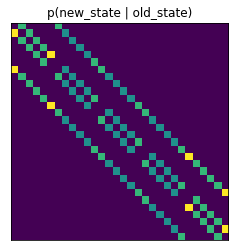

In [7]:
fig, ax = plt.subplots()
ax.imshow(p_transition)
ax.set_title('p(new_state | old_state)')
hide_ticks(ax)
plt.show()

#### Sample paths

I can also generate a few path examples to see if they look right. Later, after I have the emission distribution, I can use this code to help generate the visibles.

The `np.random.choice` comes in handy a few times. The `p` argument allows me to specify a list of probabilities for each state. I use it to sample from the `p_hidden_start` distribution and the `p_transition` distribution for a given hidden state.

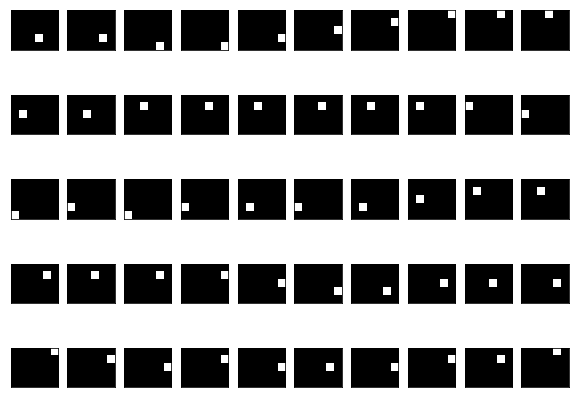

In [8]:
timesteps = 10
example_count = 5


figs, all_axs = plt.subplots(example_count, timesteps, figsize=(timesteps, 1.5 * example_count))


def plot_state_in_room(state_id):
    h = np.zeros(num_hidden_states)
    h[state_id] = 1
    return h.reshape(height, width)


for ex_i in range(example_count):
    # choose the starting state using `p_hidden_start`
    curr_hidden_state = np.random.choice(num_hidden_states, p=p_hidden_start)
    
    # plot it
    all_axs[ex_i][0].imshow(plot_state_in_room(curr_hidden_state), cmap='gray')
    hide_ticks(all_axs[ex_i][0])

    for t in range(1, timesteps):
        # use the transition matrix to get the probability distribution of the
        # next state given the current one
        curr_hidden_state = np.random.choice(
            num_hidden_states,
            p=p_transition[:, curr_hidden_state]
        )
        
        all_axs[ex_i][t].imshow(plot_state_in_room(curr_hidden_state), cmap='gray')
        hide_ticks(all_axs[ex_i][t])

plt.show()

### Emission distribution (bumps and creaks) $p(v_t \mid h_t)$

Now I need the emission distribution $p(v_t \mid h_t)$, which is the probability of a visible state given the hidden state.

In this problem, this distribution is the combination of the probability of a bump given the location, and the probability of a creak given the location. 

$$p(v_t \mid h_t) = p(v_t^{bump} \mid h_t)p(v_t^{creak} \mid h_t)$$

Both of these have two states, so combining the two gives 4 visible states for $v_t$:
 - bump and creak
 - bump and no creak
 - no bump and creak
 - no bump and no creak

#### Bumps and Creaks map, $p(v^{bump}=True \mid h_t)$

First I'll set up the bumpy and creaky aspects of the room. For example, `prob_bump_true_given_location` gives the probability distribution

$$p(v^{bump}=True \mid h_t)$$

 - There are `num_hidden_states = 30` values for $h_t$, so I need 2 sets of 30 probabilities. 
 - This isn't a probability distribution. They just need to be between 0 and 1.

I try to implement this in a similar way to Barber. Ten random spots in the room have a higher probability, and the rest has a low probability. This introduces some noise to the problem.
Here I use `np.random.choice` in a new way. In this case, I'm using it to select 10 spots to have a high probability of making a noise.

In [9]:
def make_sound_map():
    NUM_SOUNDS = 10
    LOW_PROB = 0.1
    HIGH_PROB = 0.9

    # everything has at least LOW_PROB of triggering the sound
    grid = LOW_PROB * np.ones(num_hidden_states)
    # select NUM_BUMP_CREAKS to make HIGH_PROB
    locs = np.random.choice(
        num_hidden_states, 
        size=NUM_SOUNDS, 
        replace=False
    )
    grid[locs] = HIGH_PROB
    
    return grid

prob_bump_true_given_location = make_sound_map()
prob_creak_true_given_location = make_sound_map()

### Visualizing bumps and creaks

Let's plot it!

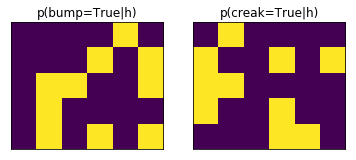

In [10]:
fig, (bump, creak) = plt.subplots(1, 2)

bump.imshow(prob_bump_true_given_location.reshape(height, width))
bump.set_title('p(bump=True|h)')
hide_ticks(bump)

creak.imshow(prob_creak_true_given_location.reshape(height, width))
creak.set_title('p(creak=True|h)')
hide_ticks(creak)

plt.show()

#### Emission distribution $p(v \mid h)$

The goal is to define the distribution $p(v \mid h)$. In `numpy`
 - The distribution gives probability of the 4 visible states given each of the 30 hidden states, so the array should be of size `(4, 30)`.
 - The distribution is conditional over the 4 states, so each column should add to 1.

To get the emission distribution in math, I'd multiply 

$$p(v \mid h) = p(v^{bump} \mid h)p(v^{creak} \mid h).$$

It's a little more complicated in code. First to get $p(v^{bump} \mid h_t)$,  I need to add a second state for $p(v^{bump}=False \mid h_t) = 1 - p(v^{bump}=True \mid h_t)$.
But I also need to flatten out the visible states from 2 2-state visible variables to one 4-state visible variable. So like Barber, I'll define the four states' probabilities by hand. 

I also define a `map_visible_state_to_bump_creak` to map from the visible state to if there was a bump and/or creak.

In [11]:
num_visible_states = 4

# prob_bump_given_state[v][state] = p(v | state)
p_emission = np.vstack((
    prob_bump_true_given_location * prob_creak_true_given_location,
    (1 - prob_bump_true_given_location) * prob_creak_true_given_location,
    prob_bump_true_given_location * (1 - prob_creak_true_given_location),
    (1 - prob_bump_true_given_location) * (1 - prob_creak_true_given_location),
))

assert np.all(np.sum(p_emission, axis=0)) == 1

# 1 means True. ex: [1, 0] means bump=True, creak=False
map_visible_state_to_bump_creak = np.vstack((
    [1, 1],
    [1, 0],
    [0, 1],
    [0, 0],
))

### visualizing $p(\textbf{v} \mid h_t)$

This one's a little tricker to visualize. I'll show it as four plots of the probability each visible state.

When I do alpha recursion the data below, the result of filtering for the first timestep will be exactly the same as one of these maps.

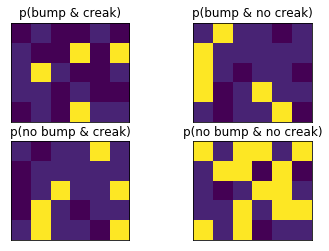

In [12]:
fig, axs = plt.subplots(2, 2)
for ax, probs, (bump, creak) in zip(axs.flatten(), p_emission, map_visible_state_to_bump_creak):
    ax.imshow(probs.reshape(height, width))
    ax.set_title(
        'p('
        + ('' if bump else 'no ') + 'bump & '
        + ('' if creak else 'no ') + 'creak)'
    )
    hide_ticks(ax)
plt.show()    

## Generating data: $\textbf{v}_{1:t}$

Now I have all of the probabilities I need. On to part 2: generating some data!

I'll do it for 10 timesteps.

In [13]:
timesteps = 10

hiddens = np.zeros(timesteps, dtype=int)
visibles = np.zeros(timesteps, dtype=int)

hiddens[0] = np.random.choice(num_hidden_states, p=p_hidden_start)
visibles[0] = np.random.choice(
    num_visible_states,
    p=p_emission[:, hiddens[0]]
)

for t in range(1, timesteps):
    hiddens[t] = np.random.choice(
        num_hidden_states,
        p=p_transition[:, hiddens[t - 1]]
    )

    visibles[t] = np.random.choice(
        num_visible_states,
        p=p_emission[:, hiddens[t]]
    )

### Visualizing

Let's take a peak at where they were moving and what sounds they made.

Visibles are plotted as a rectangle with two colors. The left is black if there was a bump and white if not. The right is black if there was a creak and white if not.

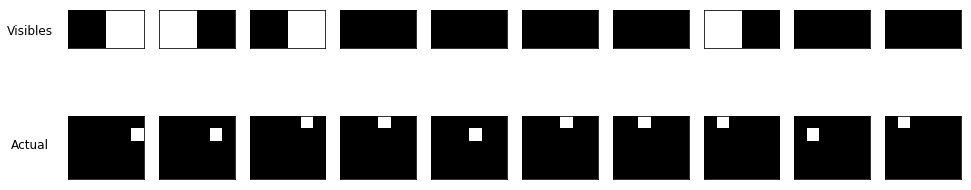

In [14]:
fig, all_axs = plt.subplots(2, timesteps, figsize=(16, 4))
all_axs = all_axs.T

VISIBLES = 0
TRUE_STATES = 1

all_axs[0][0].set_title('Visibles', x=-0.5, y=0.2)
all_axs[0][1].set_title('Actual', x=-0.5, y=0.4)

for i, (axs, hidden, visible) in enumerate(zip(all_axs, hiddens, visibles)):
    axs[VISIBLES].imshow([map_visible_state_to_bump_creak[visible]], cmap='gray')
    hide_ticks(axs[VISIBLES])    
    
    axs[TRUE_STATES].imshow(plot_state_in_room(hidden), cmap='gray')
    hide_ticks(axs[TRUE_STATES])
    
plt.show()    

## Filtering: $p(h_t \mid v_{1:t})$

Now for part 3: filtering using alpha recursion. Filtering finds the probability of the current hidden state given the visibles from all previous timesteps, as well as the transition, emission, and start probabilities.

Taking from Barber, alpha recursion gives

$$\alpha(h_t) = p(h_t, v_{1:t}) \propto p(h_t \mid v_{1:t})$$

The values of $\alpha$ are computed with

$$\alpha(h_t) = p(v_t \mid h_t) \sum_{h_{t - 1}} p(h_t \mid h_{t - 1})\alpha(h_{t - 1})$$

and

$$\alpha(h_1) = p(h_1, v_1) = p(v_1 \mid h_1)p(h_1).$$

In code I'll compute an $\alpha$ for each timestep. I'll use these to give the distribution over all states for that timestep given the visibles up until that timestep. Because I want the filtered posterior, I can rescale, so like Barber's code, I'm normalizing each $\alpha$.

In [15]:
def alpha_recursion(visibles, p_hidden_start, p_transition, p_emission):
    num_timestamps = visibles.shape[0]
    num_hidden_states = p_transition.shape[0]
    
    # There will be one alpha for each timestamp 
    alphas = np.zeros((num_timestamps, num_hidden_states))

    # alpha(h_1) = p(h_1) * p(v_1 | h_1)
    alphas[0] = p_hidden_start * p_emission[visibles[0]]

    # normalize to avoid overflow
    alphas[0] /= np.sum(alphas[0])
    for t in range(1, num_timestamps):
        # p(v_s | h_s)
        # size: new_states
        corrector = p_emission[visibles[t]]
        
        # sum over all hidden states for the previous timestep and multiply the 
        # transition prob by the previous alpha
        # transition_matrix size: new_state x old_state
        # alphas[t_minus_1].T size: old_state x 1
        # predictor size: new_state x 1,
        predictor = p_transition @ alphas[t - 1, None].T

        # alpha(h_s)
        alphas[t, :] = corrector * predictor[:, 0]

        # normalize
        alphas[t] /= np.sum(alphas[t])

    return alphas

alphas = alpha_recursion(
    visibles, 
    p_hidden_start,
    p_transition,
    p_emission,
)

assert np.all(np.isclose(np.sum(alphas, axis=1), 1))

### Visualizing

Again, but with the predictions!

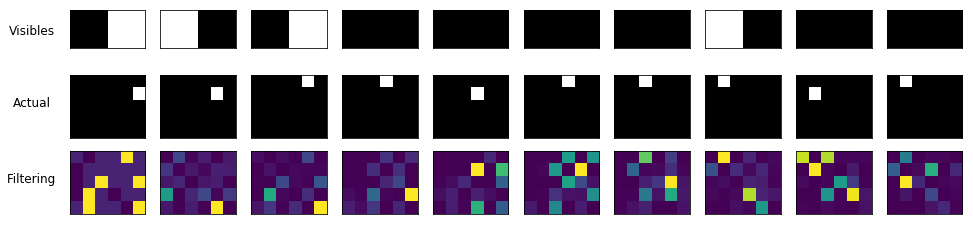

In [16]:
fig, all_axs = plt.subplots(3, timesteps, figsize=(16, 4))
all_axs = all_axs.T

VISIBLES = 0
TRUE_STATES = 1
FILTERING = 2

all_axs[0][VISIBLES].set_title('Visibles', x=-0.5, y=0.2)
all_axs[0][TRUE_STATES].set_title('Actual', x=-0.5, y=0.4)
all_axs[0][FILTERING].set_title('Filtering', x=-0.5, y=0.4)

for i, (axs, hidden, visible, alpha) in enumerate(zip(all_axs, hiddens, visibles, alphas)):
    axs[VISIBLES].imshow([map_visible_state_to_bump_creak[visible]], cmap='gray')
    hide_ticks(axs[VISIBLES])    
    
    axs[TRUE_STATES].imshow(plot_state_in_room(hidden), cmap='gray')
    hide_ticks(axs[TRUE_STATES])
    
    axs[FILTERING].imshow(alpha.reshape(height, width))
    hide_ticks(axs[FILTERING])      
    
plt.show()